# 加载数据 

In [13]:
import sys
import numpy as np
import matplotlib.pyplot as plt
markers = ["d", "o", "v", "^", "<", ">", "1", "X", "p", "P", "*", "+"]
color = ['blueviolet','blue',"green",'orange','red','m']
fmt = ['om','og','or','ok','oy','om']
bands = ['u','g','r','i','z','y']

In [14]:
# 使用 seaborn 的颜色调色板
import seaborn as sns
colors = sns.color_palette("bright", n_colors=10)

In [15]:
from matplotlib import font_manager
font_manager.fontManager.addfont("/home/yltang/data/Times_New_Roman.ttf")
plt.style.use("seaborn-v0_8-paper")
font1 = {'family': 'Times New Roman',
         #'weight': 'normal',
         #'size':20,
         }

In [16]:
sample=0

In [ ]:
#归一化数据
def data_normal(data, max_flux):
    #max_flux = np.max(data[:, :, :3])
    for i in range(data.shape[0]): 
        max_flux_ = np.max(data[i, :, :3])
        for j in range(3):
            data[i, :, j] = (data[i, :, j]/(np.abs(max_flux_)+1)) * (np.log(np.abs(max_flux_+10)+10)/np.log(max_flux))
            data[i, :, j+3] = (data[i, :, j+3]/(np.abs(max_flux_)+1)) *  (np.log(np.abs(max_flux_+10)+10)/np.log(max_flux))
    return data

In [18]:
# data mask
mask_time = 6
def data_mask(data):
    data[:, mask_time:, :]=0
    return data

In [19]:
labeled_data_file = np.load("/home/yltang/data/work_1/data_3/train_data.npz")
labeled_data = labeled_data_file["data"]
labeled_label_file = np.load("/home/yltang/data/work_1/data_3/train_label.npz")
labeled_label = labeled_label_file["data"]

In [20]:
unlabeled_data_file = np.load("/home/yltang/data/work_1/data_3/test_data.npz")
unlabeled_data = unlabeled_data_file["data"]
unlabeled_label_file = np.load("/home/yltang/data/work_1/data_3/test_label.npz")
unlabeled_label = unlabeled_label_file["data"]

In [ ]:
max_flux = np.max(labeled_data[:, :, :3])
mask_data = data_mask(data=data.copy())
mask_labeled_data = data_mask(data=labeled_data.copy())

In [ ]:
mask_data = data_normal(data=mask_data, max_flux=max_flux)
mask_labeled_data = data_normal(data=mask_labeled_data, max_flux=max_flux)
data = data_normal(data=data, max_flux=max_flux)

[0. 0. 0. 0. 1. 0. 0. 0. 0.]


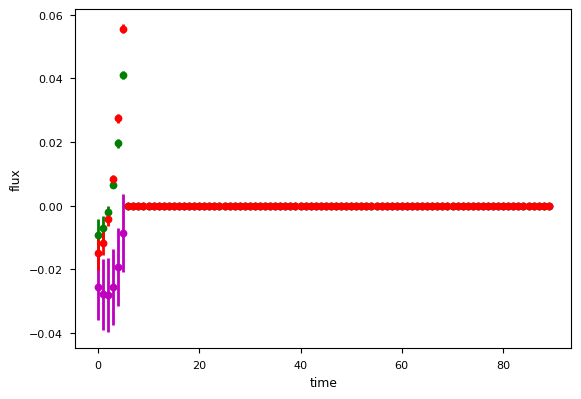

In [25]:
sample += 1
for i in range(3):
    mjd_ = np.linspace(0,89, 90)
    flux_ = mask_labeled_data[sample, :, i]
    flux_err_ = mask_labeled_data[sample, :, i+3]
    #print(flux_err_)
    plt.errorbar(x=mjd_, y=flux_, yerr=flux_err_, fmt=fmt[i], elinewidth=2, capsize=2)
    plt.xlabel("time")
    plt.ylabel("flux")

print(labeled_label[sample])

[0. 0. 0. 0. 1. 0. 0. 0. 0.]


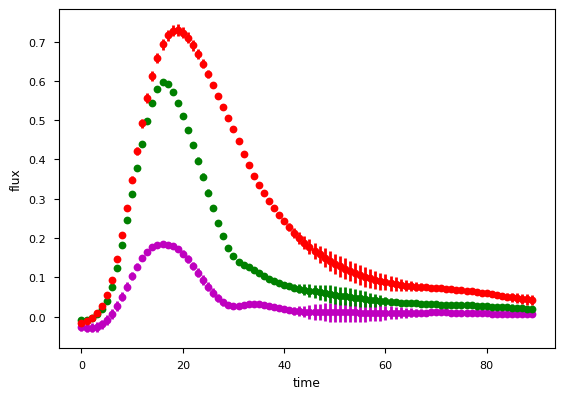

In [26]:
for i in range(3):
    mjd_ = np.linspace(0,89, 90)
    flux_ = labeled_data[sample, :, i]
    flux_err_ = labeled_data[sample, :, i+3]
    #print(flux_err_)
    plt.errorbar(x=mjd_, y=flux_, yerr=flux_err_, fmt=fmt[i], elinewidth=2, capsize=2)
    plt.xlabel("time")
    plt.ylabel("flux")

print(labeled_label[sample])

# 构建模型 

In [27]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

2025-02-17 16:47:13.159222: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-17 16:47:13.171569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-17 16:47:13.186450: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-17 16:47:13.190964: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-17 16:47:13.202191: I tensorflow/core/platform/cpu_feature_guar

In [28]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [29]:
#基本参数
num_time_steps = labeled_data.shape[1]
num_features = labeled_data.shape[2]
num_time_steps, num_features

(90, 6)

# 加载和测试模型

In [19]:
from keras.models import load_model
vae_decoder = load_model(f"/home/yltang/data/work_1/results_1/LSTM_decoder_{mask_time}.keras")
vae_encoder = load_model(f"/home/yltang/data/work_1/results_1/LSTM_encoder_{mask_time}.keras")

2025-02-16 15:27:02.549676: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14791 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


## 潜在空间展示

In [19]:
z_mean, z_log_var, pred = vae_encoder.predict(mask_unlabeled_data)

2025-02-16 10:54:35.627304: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


mean_x:0.09860768169164658 mean_y:-1.7375612258911133, var_x:0.13475719094276428 var_y:0.4005012512207031
mean_x:-1.5667363405227661 mean_y:-1.1062443256378174, var_x:0.2335689812898636 var_y:0.2518080472946167
mean_x:0.7864927649497986 mean_y:0.565044641494751, var_x:0.5717806816101074 var_y:0.2894711494445801
mean_x:-0.643556535243988 mean_y:0.797269880771637, var_x:0.052655212581157684 var_y:0.4754995107650757
mean_x:-1.4559859037399292 mean_y:0.26028773188591003, var_x:0.31496503949165344 var_y:0.16350923478603363
mean_x:-0.6569819450378418 mean_y:0.7663447856903076, var_x:0.15512067079544067 var_y:0.2599235475063324
mean_x:-0.27773699164390564 mean_y:0.4147084653377533, var_x:0.059818752110004425 var_y:0.06893742084503174
mean_x:-0.47231993079185486 mean_y:-0.45509445667266846, var_x:0.0330326221883297 var_y:0.034820567816495895


/tmp/ipykernel_3274190/351086923.py:38: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


mean_x:0.7791386842727661 mean_y:-0.8255610466003418, var_x:0.18494299054145813 var_y:0.113129161298275


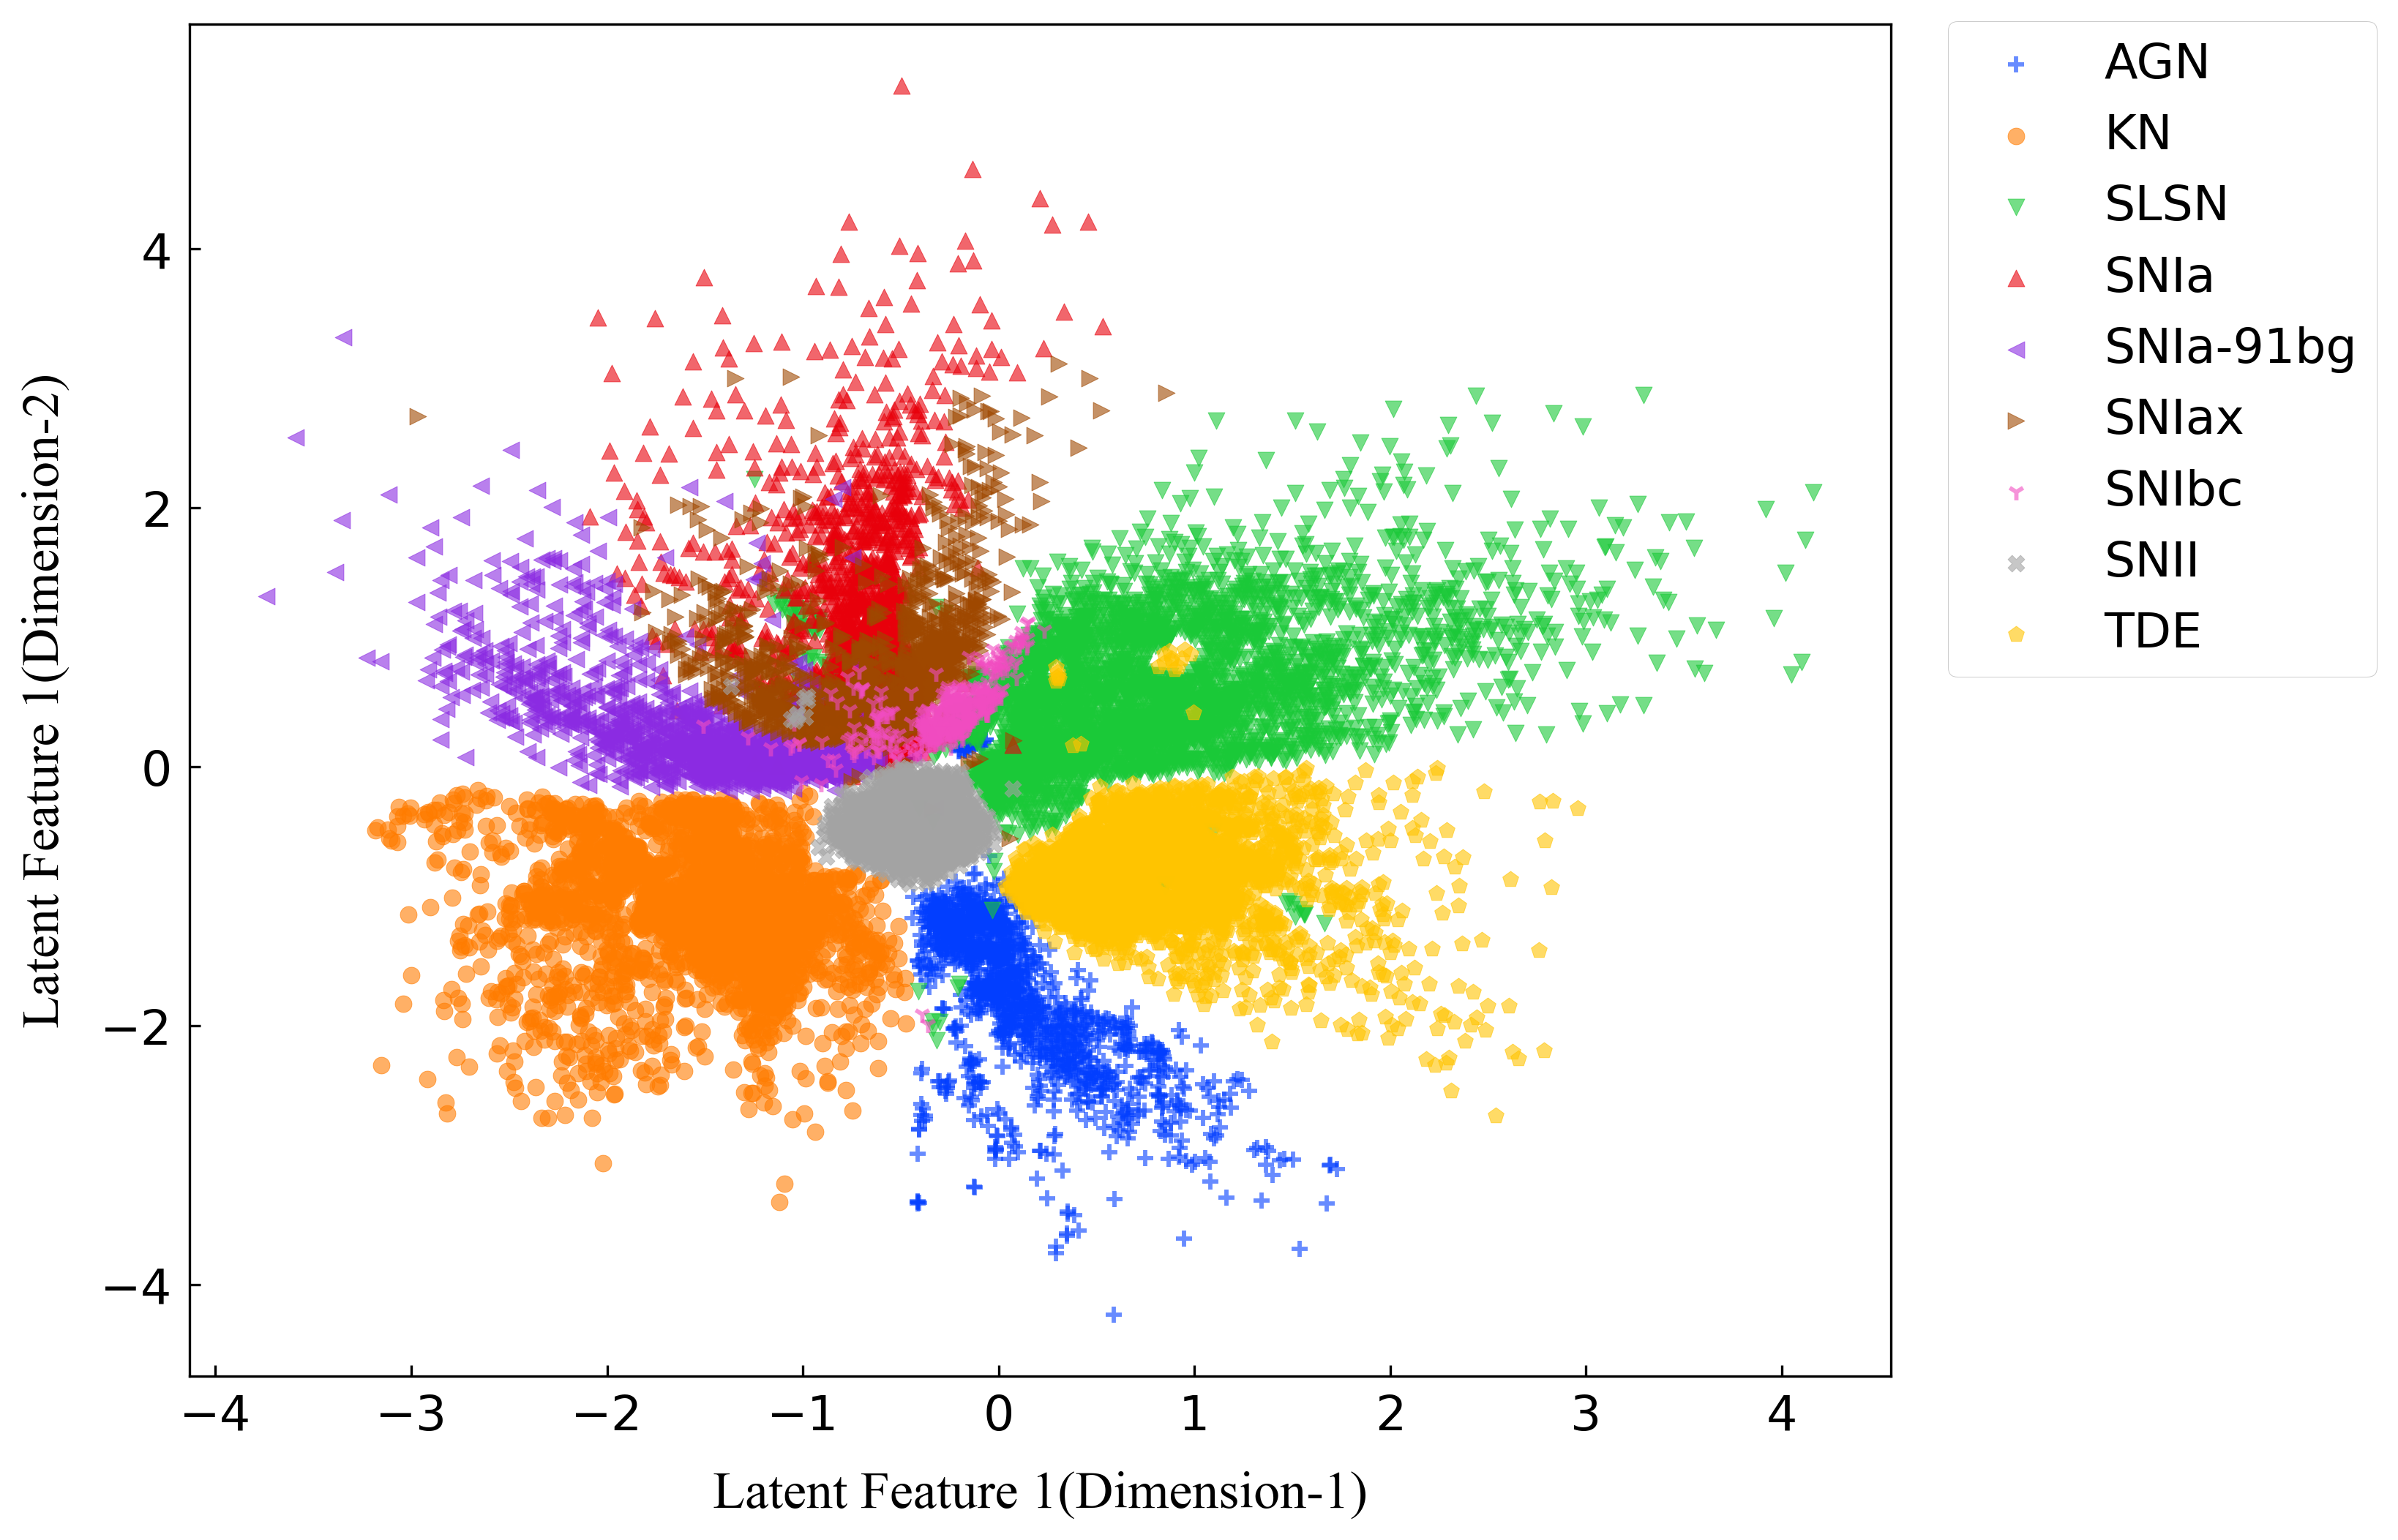

In [21]:
#plt.figure(figsize=(12,10),)
#         dpi=1000)

labels = [
 'AGN',
 'KN',
 'SLSN',
 'SNIa',
 'SNIa-91bg',
 'SNIax',
 'SNIbc',
 'SNII',
 'TDE']
markers = ["+", "o", "v", "^", "<", ">", "1", "X", "p", "P", "*", "d"]

figure,ax = plt.subplots(1,1,
                        figsize=(10,8),
                        dpi=300,
                        )
mean_x_list = []
var_x_list = []
mean_y_list = []
var_y_list = []
for i in range(len(colors)-1):
    plotlist = []
    for j in range(z_mean.shape[0]):
        #if np.argmax(test_label[j,0,:])==i:
        if np.argmax(unlabeled_label[j,:])==i:
            plotlist.append(j)
    mean_x = np.mean(z_mean[plotlist, 0])
    mean_y = np.mean(z_mean[plotlist, 1])
    var_x = np.var(z_mean[plotlist,0])
    var_y = np.var(z_mean[plotlist,1])
    mean_x_list.append(mean_x)
    var_x_list.append(var_x)
    print(f"mean_x:{mean_x} mean_y:{mean_y}, var_x:{var_x} var_y:{var_y}")
    
    ax.scatter(
        z_mean[plotlist, 0],
        z_mean[plotlist, 1],
        c=colors[i],
        s=30,
        label=labels[i],
        marker=markers[i],
        alpha=0.6
                )
    
ax.set_xlabel("Latent Feature 1(Dimension-1)",fontsize="xx-large",labelpad=10,fontproperties="Times New Roman")
ax.set_ylabel("Latent Feature 1(Dimension-2)",fontsize="xx-large",labelpad=10,fontproperties="Times New Roman")
#plt.legend(fontsize="xx-large",bbox_to_anchor=(1.3, 1),loc="upper right",
#         prop=font1,
#         borderaxespad=0.)

ax.tick_params(axis='y',
                     labelsize=16, # y轴字体大小设置
                     #color='r',    # y轴标签颜色设置  
                     #labelcolor='b', # y轴字体颜色设置
                     direction='in' # y轴标签方向设置
                      ) 
    
ax.tick_params(axis='x',
                     labelsize=16, # y轴字体大小设置
                     #color='r',    # y轴标签颜色设置  
                     #labelcolor='b', # y轴字体颜色设置
                     direction='in' # y轴标签方向设置
                      ) 
ax.legend(fontsize=16,
                      bbox_to_anchor=(0,0,1.3, 1.02),
                      loc="best",
                      framealpha=1.0,
                     )

plt.savefig(f"latent_distribution.jpg",bbox_inches='tight')
plt.show()

mean_x:-6.46982479095459 mean_y:-5.072808742523193, var_x:0.19082066416740417 var_y:0.516675591468811
mean_x:-4.037261009216309 mean_y:-3.9238197803497314, var_x:1.2049834728240967 var_y:0.7196881771087646
mean_x:-6.770113945007324 mean_y:-7.107545852661133, var_x:0.5343454480171204 var_y:0.45408427715301514
mean_x:-6.193783760070801 mean_y:-6.168835163116455, var_x:0.14599162340164185 var_y:0.3193214237689972
mean_x:-4.996927261352539 mean_y:-5.6715850830078125, var_x:0.49404188990592957 var_y:0.3270530104637146
mean_x:-6.490377902984619 mean_y:-6.435907363891602, var_x:0.1560596525669098 var_y:0.2773819863796234
mean_x:-6.959368705749512 mean_y:-6.496440410614014, var_x:0.3046501874923706 var_y:0.10998369753360748
mean_x:-7.150108814239502 mean_y:-6.903956890106201, var_x:0.11391139775514603 var_y:0.20396190881729126


/tmp/ipykernel_3274190/523528754.py:32: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


mean_x:-5.90644645690918 mean_y:-5.7333550453186035, var_x:0.353311687707901 var_y:0.3241313695907593


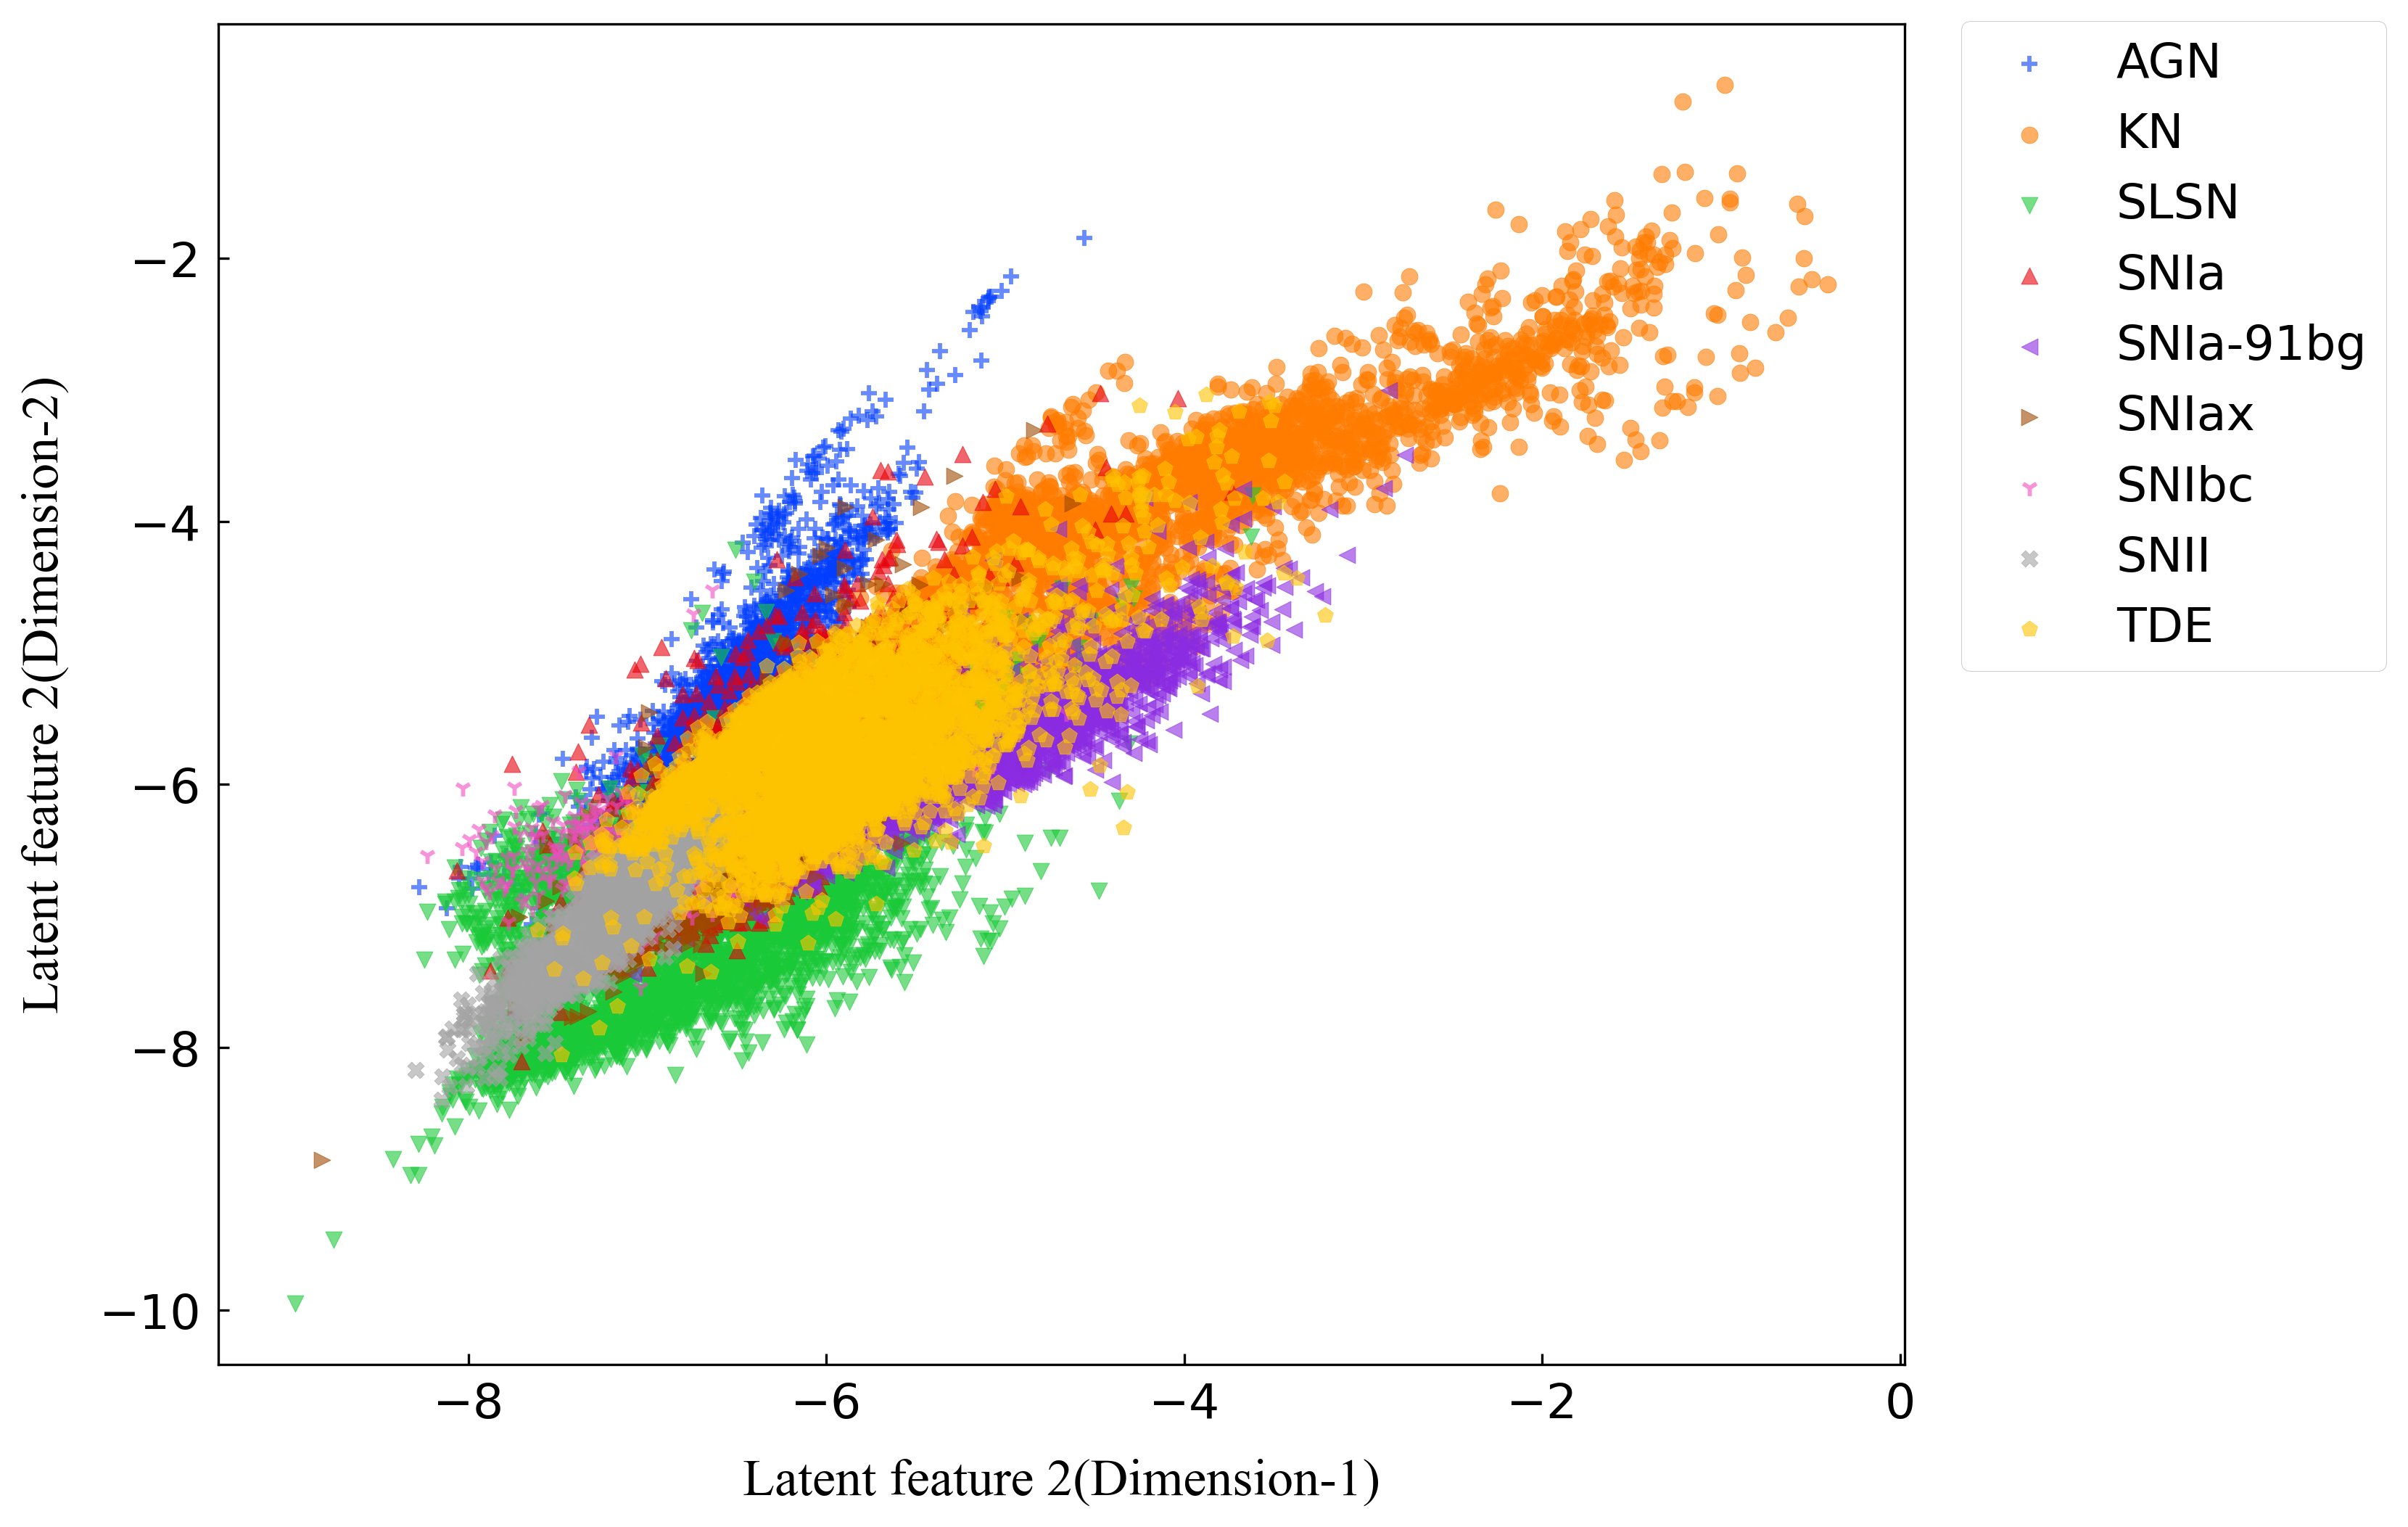

In [24]:
#plt.figure(figsize=(12,10),)
#         dpi=1000)

labels = [
 'AGN',
 'KN',
 'SLSN',
 'SNIa',
 'SNIa-91bg',
 'SNIax',
 'SNIbc',
 'SNII',
 'TDE']
markers = ["+", "o", "v", "^", "<", ">", "1", "X", "p", "P", "*", "d"]

figure,ax = plt.subplots(1,1,
                        figsize=(10,8),
                        dpi=300,
                        )
for i in range(len(colors)-1):
    plotlist = []
    for j in range(z_log_var.shape[0]):
        #if np.argmax(test_label[j,0,:])==i:
        if np.argmax(unlabeled_label[j,:])==i:
            plotlist.append(j)
    mean_x = np.mean(z_log_var[plotlist, 0])
    mean_y = np.mean(z_log_var[plotlist, 1])
    var_x = np.var(z_log_var[plotlist,0])
    var_y = np.var(z_log_var[plotlist,1])
    print(f"mean_x:{mean_x} mean_y:{mean_y}, var_x:{var_x} var_y:{var_y}")
    
    ax.scatter(
        z_log_var[plotlist, 0],
        z_log_var[plotlist, 1],
        c=colors[i],
        s=30,
        label=labels[i],
        marker=markers[i],
        alpha=0.6
                )
    
ax.set_xlabel("Latent feature 2(Dimension-1)",fontsize="xx-large",labelpad=10,fontproperties="Times New Roman")
ax.set_ylabel("Latent feature 2(Dimension-2)",fontsize="xx-large",labelpad=10,fontproperties="Times New Roman")
#plt.legend(fontsize="xx-large",bbox_to_anchor=(1.3, 1),loc="upper right",
#         prop=font1,
#         borderaxespad=0.)

ax.tick_params(axis='y',
                     labelsize=16, # y轴字体大小设置
                     #color='r',    # y轴标签颜色设置  
                     #labelcolor='b', # y轴字体颜色设置
                     direction='in' # y轴标签方向设置
                      ) 
    
ax.tick_params(axis='x',
                     labelsize=16, # y轴字体大小设置
                     #color='r',    # y轴标签颜色设置  
                     #labelcolor='b', # y轴字体颜色设置
                     direction='in' # y轴标签方向设置
                      ) 
ax.legend(fontsize=16,
                      bbox_to_anchor=(0,0,1.3, 1.02),
                      loc="best",
                      framealpha=1.0,
                     )

plt.savefig(f"latent_distribution_2.jpg",bbox_inches='tight')
plt.show()

## 复用模型

In [20]:
from keras.models import Model
from keras.layers import Dense

# 获取 vae_encoder 除了最后一层外的所有层
partial_vae_encoder = Model(
    inputs=vae_encoder.input,
    outputs=vae_encoder.layers[-6].output  # 假设你想去掉的是最后一层
)

# 冻结 partial_vae_encoder 的所有层
for layer in partial_vae_encoder.layers:
    layer.trainable = False

# 获取新模型的输出
new_output = partial_vae_encoder.output

In [21]:
new_output.shape

(None, 100)

In [22]:
# 添加新的全连接层，并为每层提供唯一的名称
x = Dense(64, activation='relu', name='dense_1')(new_output)
x = Dense(32, activation='relu', name='dense_2')(x)
predictions = Dense(9, activation='softmax', name='dense_output')(x)  # 根据你的任务调整最后的层

# 构建新的模型
vae_model = Model(inputs=partial_vae_encoder.input, outputs=predictions)

# 编译新模型
#vae_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 打印新模型的结构以确认一切正常
vae_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 90, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 90, 6)     │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 90, 6)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 90)        │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 90, 100)   │     32,400 │ masking[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 90, 100)   │        200 │ gru[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 100)       │     60,600 │ layer_normalizat… │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100)       │        200 │ gru_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      6,464 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_output        │ (None, 9)         │        297 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 102,241 (399.38 KB)

 Trainable params: 8,841 (34.54 KB)

 Non-trainable params: 93,400 (364.84 KB)

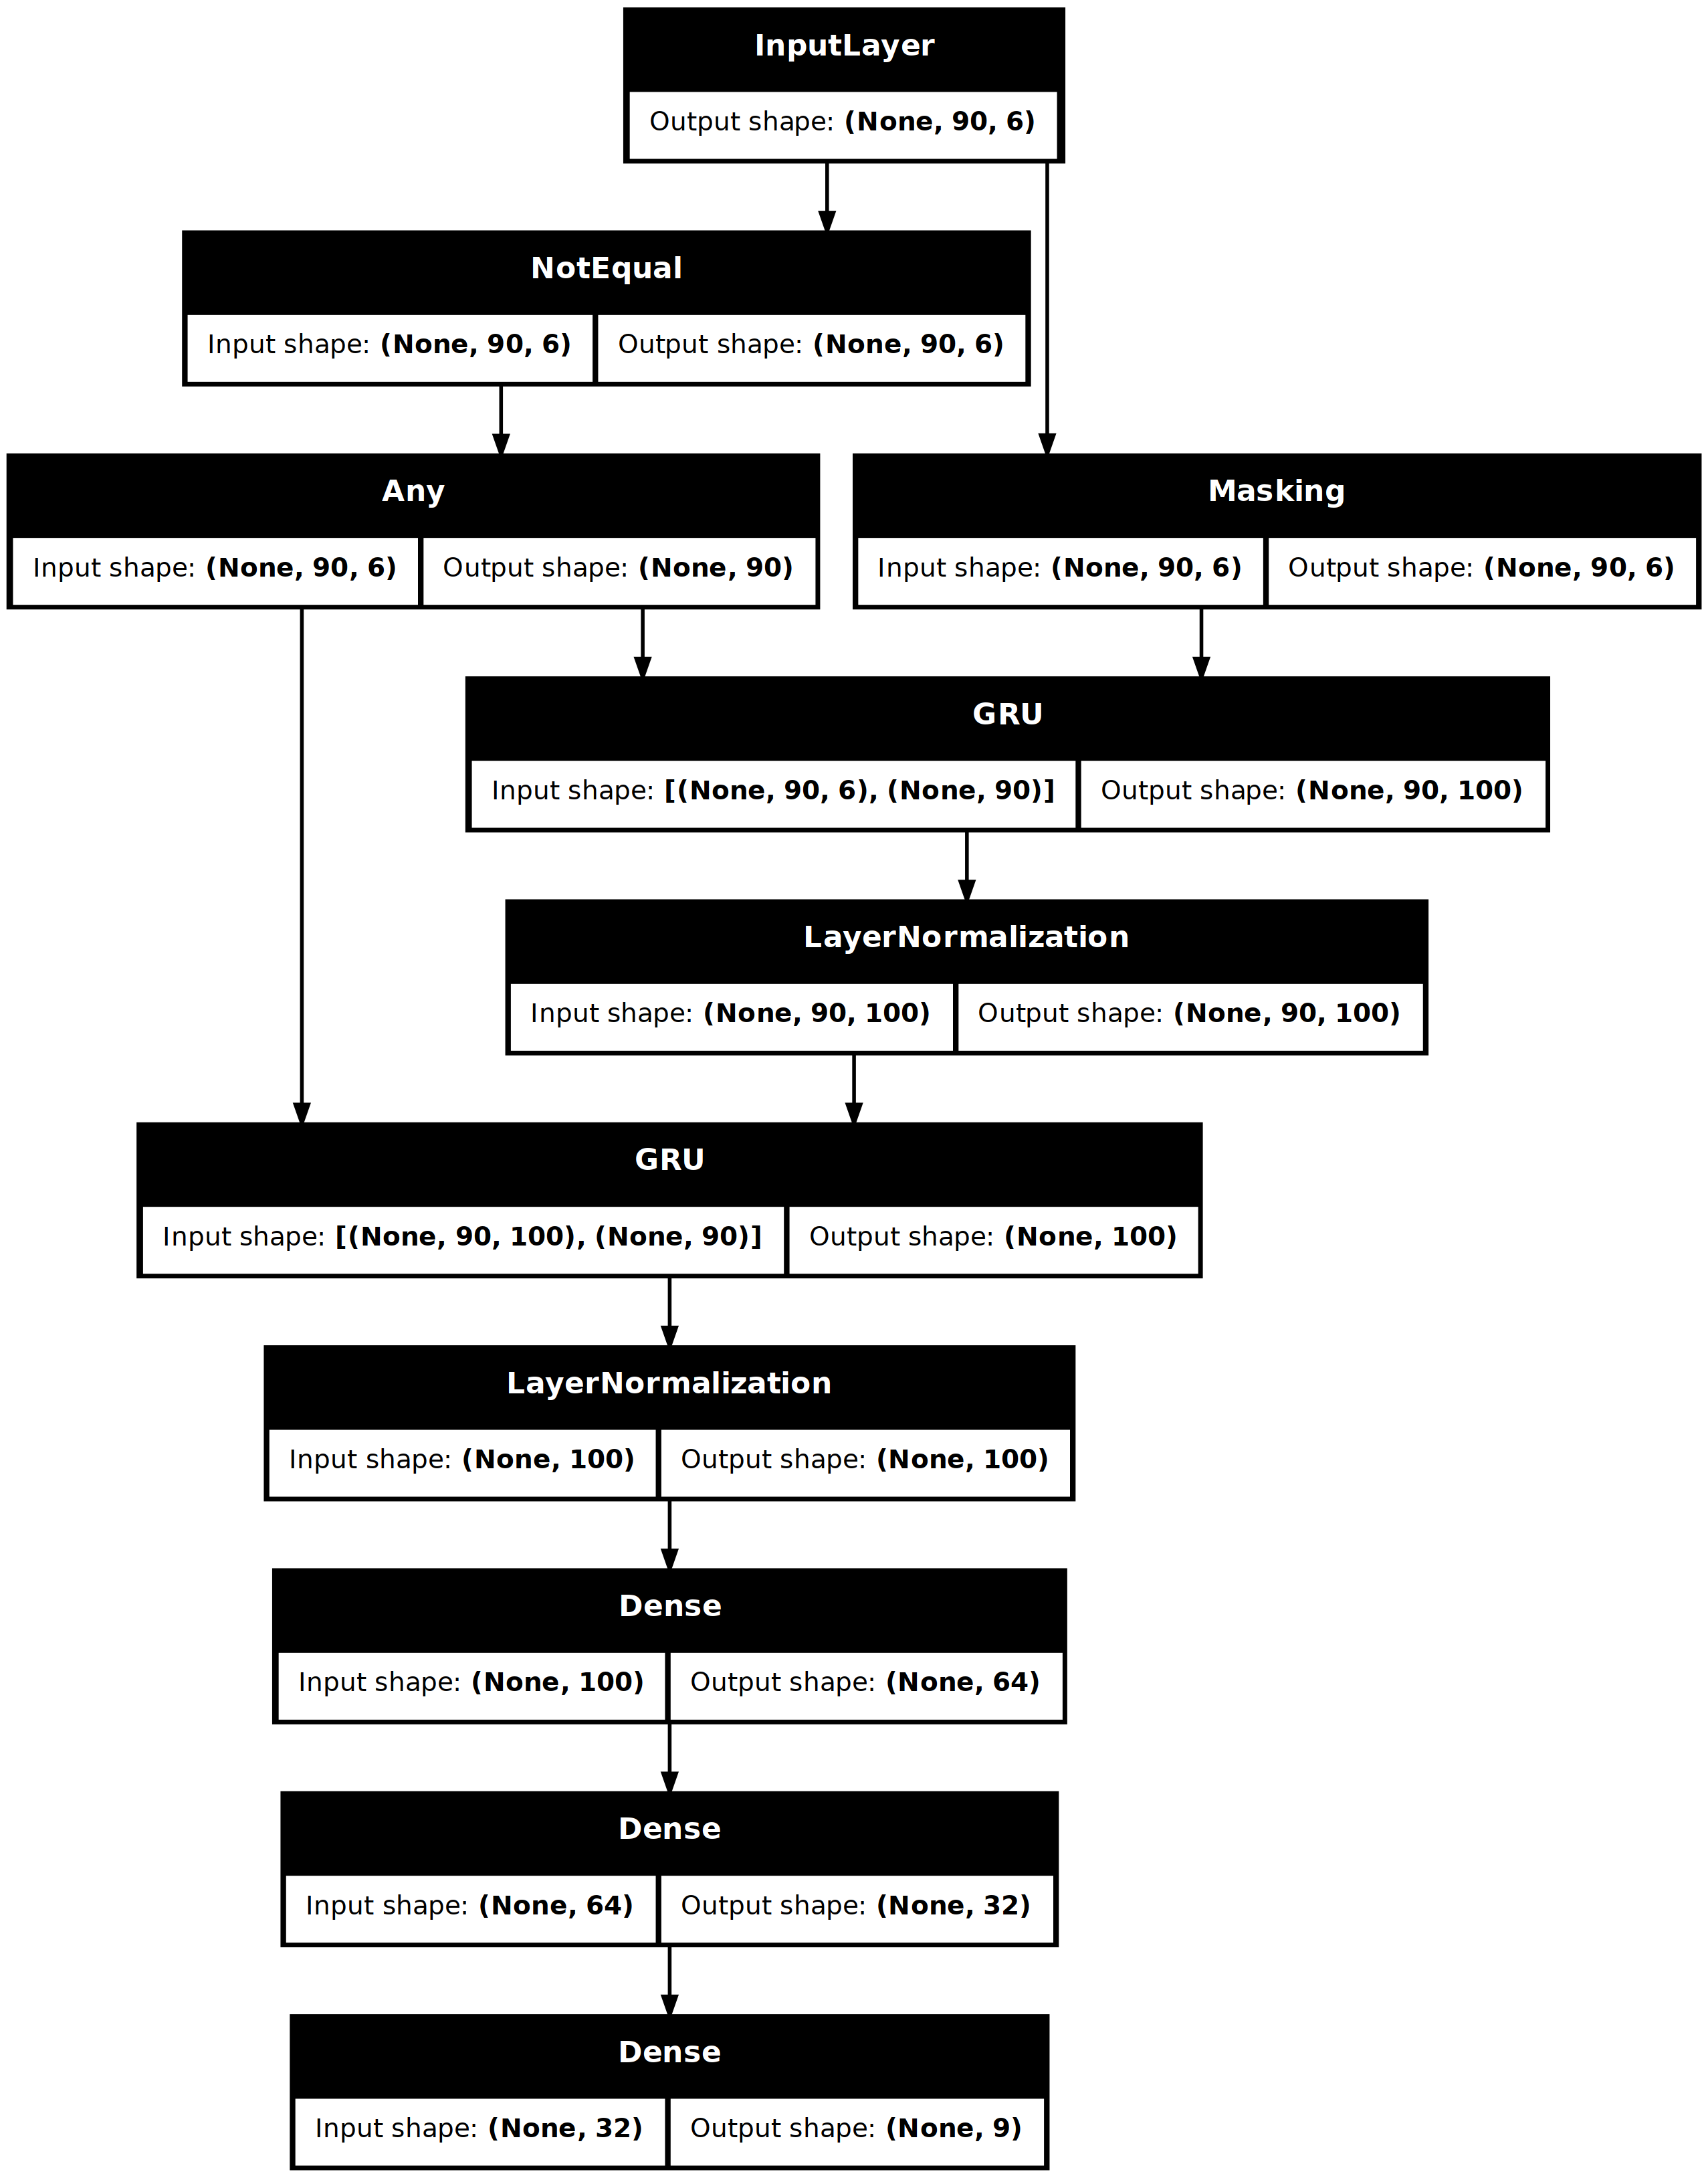

In [22]:
keras.utils.plot_model(vae_model, show_shapes=True)

In [23]:
epochs = 5000
batch_size = 512

callbacks = [
    keras.callbacks.ModelCheckpoint(
        f"vae_model.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.8, patience=50, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, verbose=1),
]
vae_model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["acc"],
)
history = vae_model.fit(
    mask_labeled_data,
    labeled_label,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/5000


2025-02-16 15:27:20.663646: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - acc: 0.2378 - loss: 2.1393 - val_acc: 0.4465 - val_loss: 1.6673 - learning_rate: 0.0010
Epoch 2/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.5015 - loss: 1.5542 - val_acc: 0.5718 - val_loss: 1.2996 - learning_rate: 0.0010
Epoch 3/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc: 0.6293 - loss: 1.2019 - val_acc: 0.6919 - val_loss: 1.0415 - learning_rate: 0.0010
Epoch 4/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - acc: 0.7219 - loss: 0.9839 - val_acc: 0.7755 - val_loss: 0.8542 - learning_rate: 0.0010
Epoch 5/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.7907 - loss: 0.7996 - val_acc: 0.8172 - val_loss: 0.7108 - learning_rate: 0.0010
Epoch 6/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.8265 - loss: 0.6740 - val_acc: 0.8368 - val_loss: 0.5985 - learning_rate: 0.0010
Epoch 7/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc: 0.8547 - loss: 0.5627 - val_acc: 0.8551 - val_loss: 0.5057 - learning_rate: 0.0010
Epoch 8/5000
6/6 ━━━━━━━━━

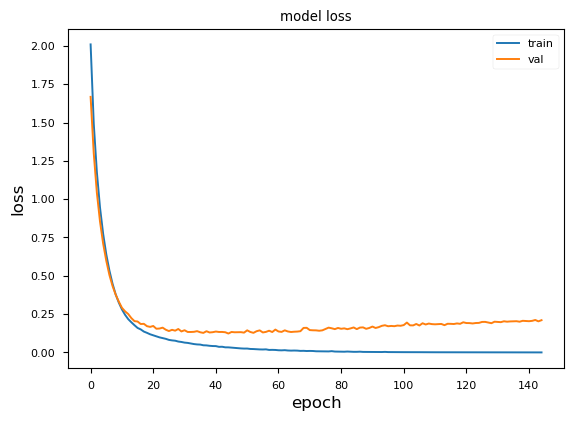

In [24]:
metric = "loss"
#metric = "acc"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
#plt.savefig(f"accuracy")
plt.show()

## 进行交叉验证

In [25]:
from keras.models import load_model
rnn = load_model(f"/home/yltang/data/work_1/vae_model.keras")

In [26]:
validation_time = 1
guess_list = []
true_list = []
pred_list = []
acc_list = []

In [27]:
sys.path.append("/home/yltang/data/work_1")
from cross_validation import Cross_Validation
cross_validation = Cross_Validation(data=mask_unlabeled_data, label=unlabeled_label)

In [28]:
#定义一个将数据打乱的函数
def data_shuffle(data, label):
    index = list(range(len(data)))
    np.random.shuffle(index)
    shuffle_data = np.zeros(shape=data.shape)
    shuffle_label = np.zeros(shape=label.shape)

    for i, j in enumerate(index):
        shuffle_data[i,:,:] = data[j,:,:]
        shuffle_label[i, :] = label[j, :]
        
    return shuffle_data, shuffle_label

## 每一次采样流程 

In [29]:
for i in range(100):
    sampling_data, sampling_label = cross_validation.test_data_generation()
    test_data = sampling_data[0]
    test_label = sampling_label[0]
    for i in range(len(sampling_data)-1):
        test_data = np.concatenate([test_data, sampling_data[i+1]], axis=0)
        test_label = np.concatenate([test_label, sampling_label[i+1]], axis=0)
    
    test_data, test_label = data_shuffle(test_data, test_label)
    test_loss, test_acc = rnn.evaluate(test_data, test_label)
    pred = rnn.predict(test_data)
    guess=[]
    for i in range (len(test_data)):
        guess.append(np.argmax(pred[i,:]))
    true=[]
    for i in range (len(test_label)):
        true.append(np.argmax(test_label[i,:]))
    
    guess_list.append(guess)
    true_list.append(true)
    pred_list.append(pred)
    acc_list.append(test_acc)

1439 0
2800 1
3500 2
3000 3
1552 4
1354 5
441 6
1739 7
3769 8
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8481 - loss: 0.5910
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1439 0
2800 1
3500 2
3000 3
1552 4
1354 5
441 6
1739 7
3769 8
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.8352 - loss: 0.6418
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1439 0
2800 1
3500 2
3000 3
1552 4
1354 5
441 6
1739 7
3769 8
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.8314 - loss: 0.6395
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1439 0
2800 1
3500 2
3000 3
1552 4
1354 5
441 6
1739 7
3769 8
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8164 - loss: 0.6983
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1439 0
2800 1
3500 2
3000 3
1552 4
1354 5
441 6
1739 7
3769 8
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8492 - loss: 0.5903
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1439 0
2800 1
3500 2
3000 3
1552 4
1354 5
441 6
1739 7
3769 8
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8115 - loss: 0.7799
29/29 ━━━━━━━━━━━━━━━━━━━

In [30]:
len(true_list), len(guess_list)

(100, 100)

In [31]:
np.mean(acc_list)

0.8354999989271163

In [32]:
np.std(acc_list)

0.011625188573748212

## 计算混淆矩阵

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
cm_list = []
for i in range(len(guess_list)):
    confusion = confusion_matrix(true_list[i],guess_list[i],normalize='true')
    cm_list.append(confusion)

In [34]:
len(cm_list)

100

### 计算混淆矩阵的均值和方差

In [35]:
import numpy as np

def calculate_confusion_matrix_stats(confusion_matrices):
    # 将列表中的所有混淆矩阵转换为一个三维numpy数组
    matrices_array = np.array(confusion_matrices)
    
    # 计算每个位置的均值，得到一个与单个混淆矩阵形状相同的数组
    mean_matrix = matrices_array.mean(axis=0)
    
    # 计算每个位置的方差，得到一个与单个混淆矩阵形状相同的数组
    variance_matrix = matrices_array.var(axis=0)
    
    return mean_matrix, variance_matrix

# 调用函数并打印结果
mean, var = calculate_confusion_matrix_stats(cm_list)
print("Mean matrix:\n", mean.shape)
print("Variance matrix:\n", var.shape)

Mean matrix:
 (9, 9)
Variance matrix:
 (9, 9)


In [36]:
import matplotlib

In [37]:
def heatmap(mean_matrix, var_matrix, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", mean_fontsize=12, var_fontsize=10, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    This function also annotates each cell with the mean value and adds variance below it.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(mean_matrix, **kwargs)

    # Annotate heatmap with mean values using specified fontsize
    annotate_heatmap(im, data=mean_matrix, valfmt="{x:.2f}", fontsize=mean_fontsize)
    """
    # 添加方差注释到每一个单元格下面，使用指定的方差字体大小
    for i in range(mean_matrix.shape[0]):
        for j in range(mean_matrix.shape[1]):
            ax.text(j, i + 0.3, f"±{var_matrix[i, j]:.2e}", 
                    ha='center', va='center', color='black', fontsize=var_fontsize)
    """
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw, fraction=0.046)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(mean_matrix.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(mean_matrix.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labelsize=12,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(mean_matrix.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(mean_matrix.shape[0]+1)-.5, minor=True)
    ax.set_ylabel('True Label', fontsize="xx-large", labelpad=20, fontproperties="Times New Roman")
    ax.set_xlabel('Predicted Label', fontsize="xx-large", labelpad=30, fontproperties="Times New Roman", loc="center")
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, fontsize=12, **textkw):
    """
    A function to annotate a heatmap with the given data.
    """
    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), fontsize=fontsize, **kw)
            texts.append(text)

    return texts

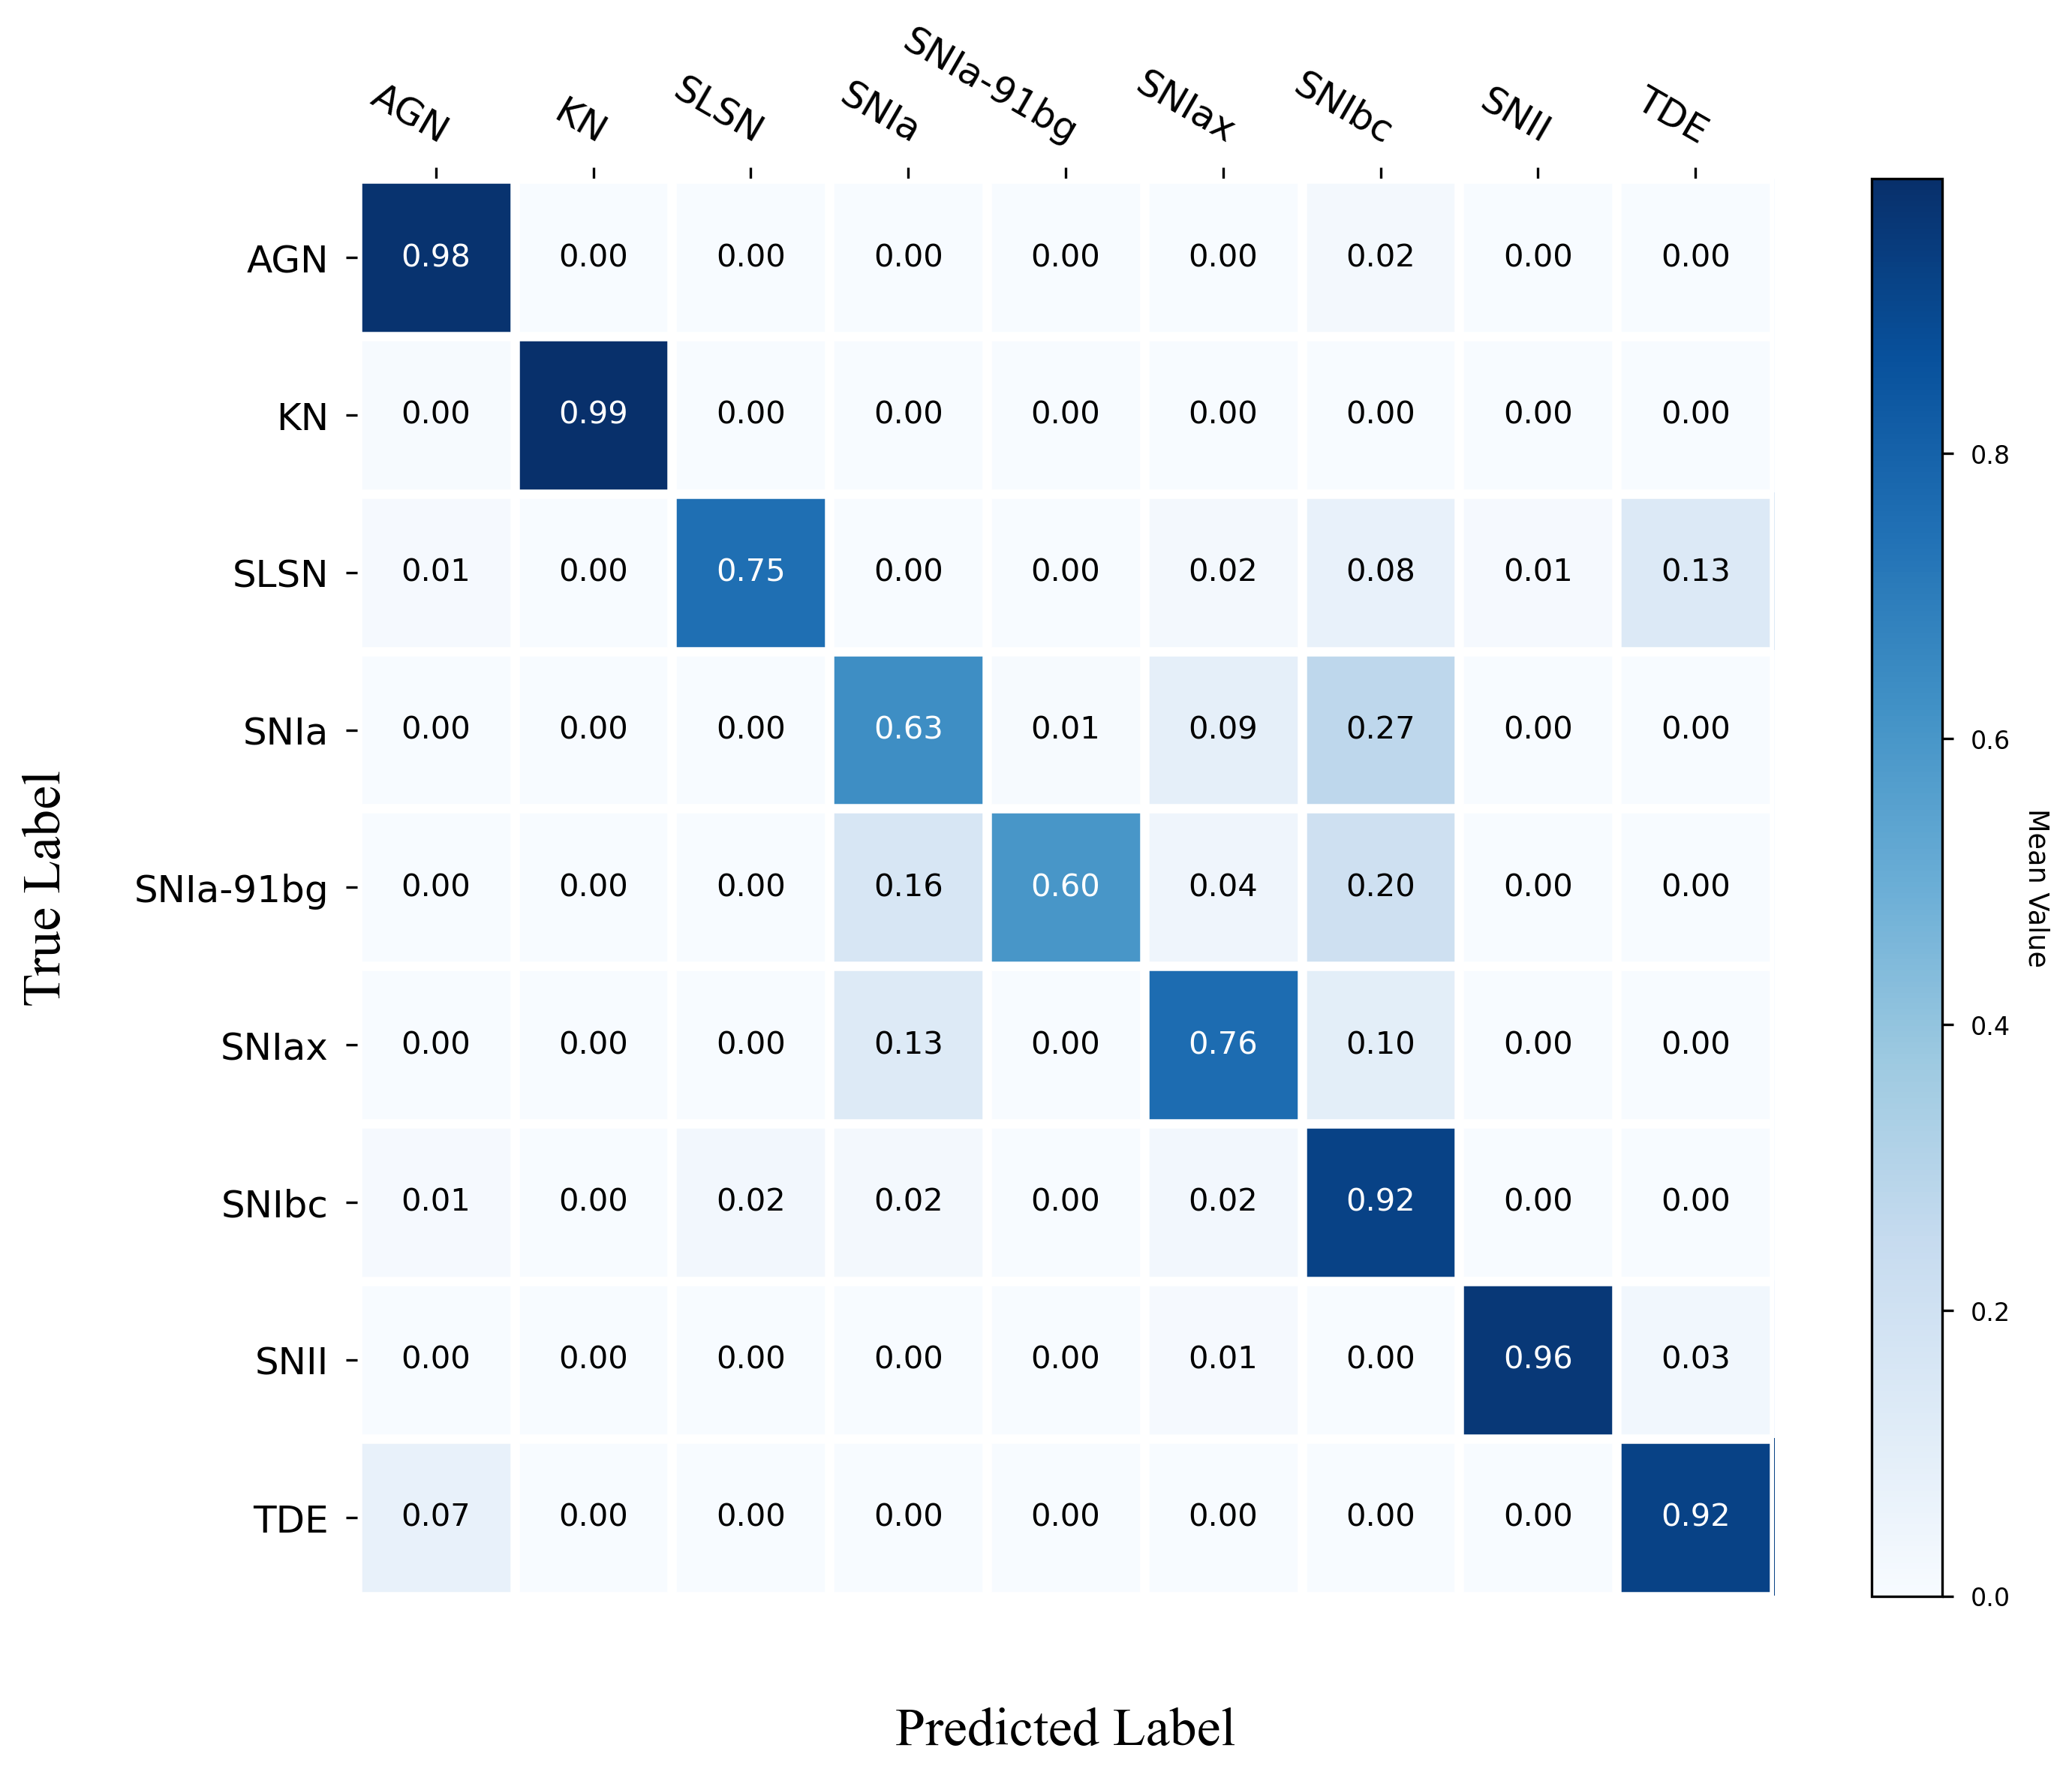

In [38]:
fig, ax = plt.subplots(figsize=(10,8),
                      dpi=300)
im, cbar = heatmap(mean_matrix=mean, var_matrix=var, row_labels = [
 'AGN',
 'KN',
 'SLSN',
 'SNIa',
 'SNIa-91bg',
 'SNIax',
 'SNIbc',
 'SNII',
 'TDE']
,col_labels=[
 'AGN',
 'KN',
 'SLSN',
 'SNIa',
 'SNIa-91bg',
 'SNIax',
 'SNIbc',
 'SNII',
 'TDE'], ax=ax,
cmap='Blues',cbarlabel="Mean Value", mean_fontsize=10, var_fontsize=5)
#texts = annotate_heatmap(im, valfmt="{x:.2f}")
fig.tight_layout()
#plt.savefig(f"Confusion_matrix_{mask_time}_1.jpg",bbox_inches='tight')
plt.show()

### 通过混淆矩阵计算查准率和查全率

In [39]:
recall_list = []
precision_list = []

In [40]:
#precision recall
for cm_ in cm_list:
    recall = np.diag(cm_) / np.sum(cm_, axis = 1)
    precision = np.diag(cm_) / np.sum(cm_, axis = 0)
    recall_list.append(recall)
    precision_list.append(precision)

In [41]:
import numpy as np

def calculate_average_vector(vector_list):
    """
    Calculate the average vector from a list of 1D numpy vectors.
    
    Parameters:
    - vector_list: A list of 1D numpy arrays (vectors).
    
    Returns:
    - A numpy array representing the average vector.
    """
    stacked_vectors = np.vstack(vector_list)
    average_vector = np.mean(stacked_vectors, axis=0)
    return average_vector


def calculate_variance_vector(vector_list):
    """
    Calculate the variance vector from a list of 1D numpy vectors.
    
    Parameters:
    - vector_list: A list of 1D numpy arrays (vectors).
    
    Returns:
    - A numpy array representing the variance vector.
    """
    stacked_vectors = np.vstack(vector_list)
    variance_vector = np.var(stacked_vectors, axis=0, ddof=0)  # Population variance (ddof=0)
    # If you want to calculate sample variance instead, set ddof=1
    return variance_vector


# 示例用法
if __name__ == "__main__":
    # 创建一个由一维向量组成的列表
    vectors = [
        np.array([1, 2, 3]),
        np.array([4, 5, 6]),
        np.array([7, 8, 9])
    ]
    
    # 计算平均值向量
    avg_vector = calculate_average_vector(vectors)
    
    # 计算方差向量
    var_vector = calculate_variance_vector(vectors)
    
    print("Average Vector:", avg_vector)
    print("Variance Vector:", var_vector)

Average Vector: [4. 5. 6.]
Variance Vector: [6. 6. 6.]


In [42]:
avg_precision = calculate_average_vector(precision_list)
var_precision = calculate_variance_vector(precision_list)

avg_recall = calculate_average_vector(recall_list)
var_recall = calculate_variance_vector(recall_list)

In [43]:
print("Precision mean:", avg_precision)
print("Precision var:", var_precision)

Precision mean: [0.98890182 0.99085843 0.89535562 0.88367642 0.99551087 0.91818439
 0.53689593 0.98859744 0.99849582]
Precision var: [9.97364876e-05 7.63066013e-05 6.39268744e-04 1.19846975e-03
 5.92708989e-05 9.16901469e-04 6.92883182e-04 1.27688477e-04
 1.28229505e-05]


In [44]:
print("Recall mean:", avg_recall)
print("Recall var:", var_recall)

Recall mean: [0.9286 0.9996 0.9498 0.6592 0.6285 0.7703 0.9511 0.9945 0.9899]
Recall var: [5.90040e-04 3.84000e-06 4.47960e-04 2.21936e-03 2.02475e-03 1.72291e-03
 3.47790e-04 4.07500e-05 8.69900e-05]


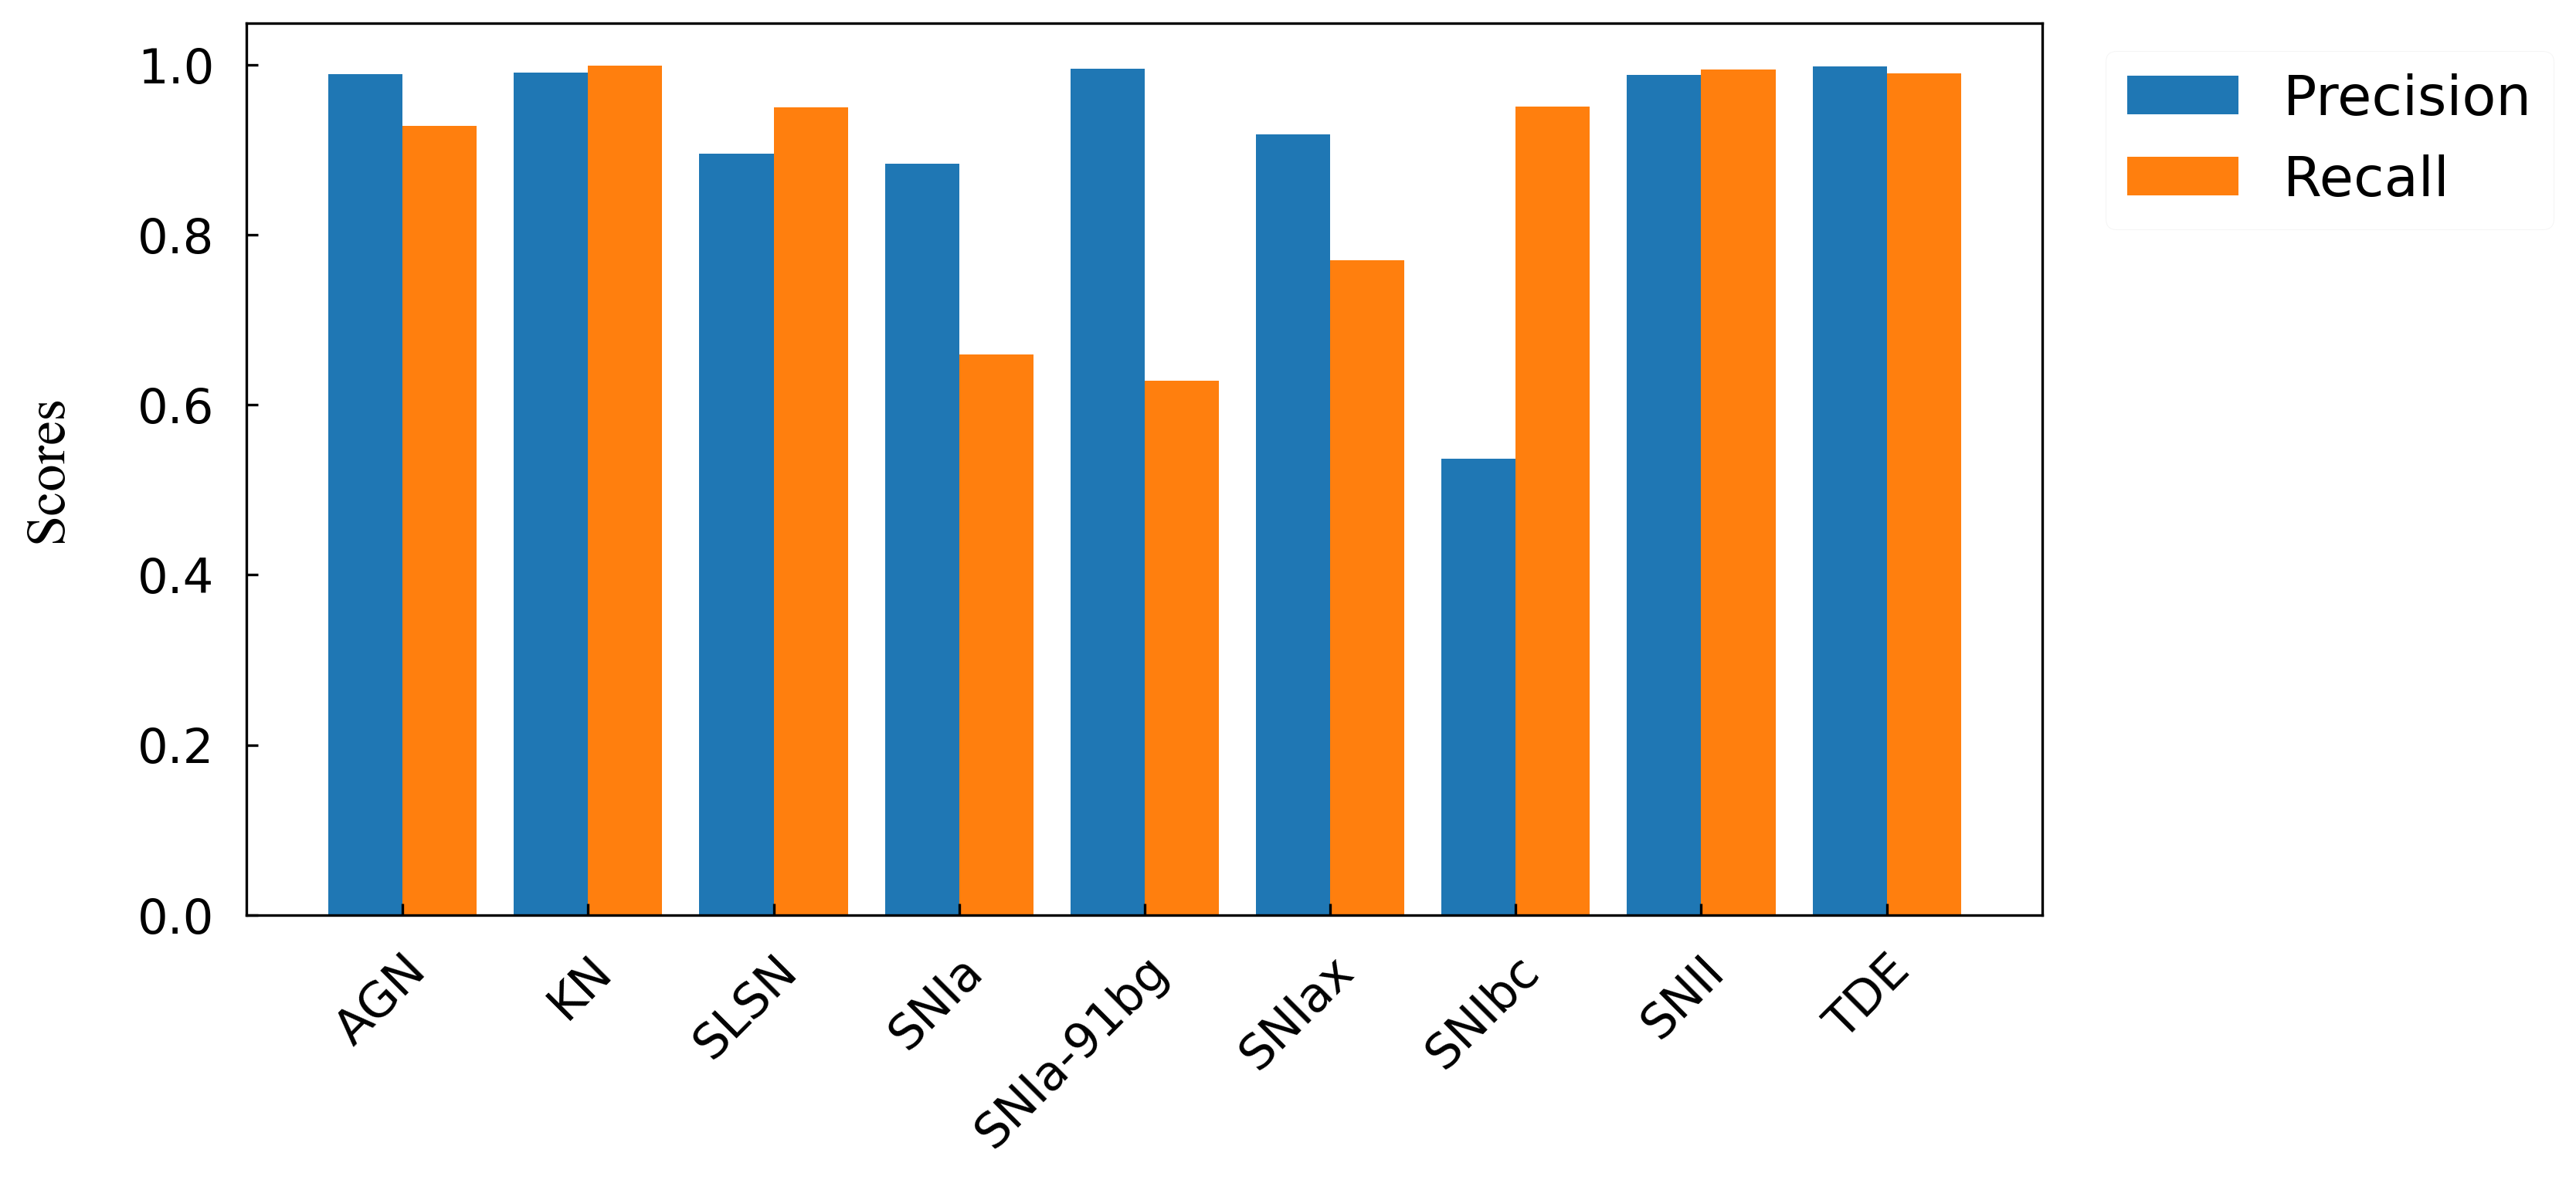

In [45]:
fig, ax = plt.subplots(figsize=(10,5),
                       dpi=300
                      )
labels = [
 'AGN',
 'KN',
 'SLSN',
 'SNIa',
 'SNIa-91bg',
 'SNIax',
 'SNIbc',
 'SNII',
 'TDE']
x = np.arange(9)  # the label locations
width = 0.4  # the width of the bars
rects1 = ax.bar((x- width/2), avg_precision, width, label='Precision')
rects2 = ax.bar((x+ width/2), avg_recall, width, label='Recall')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores',fontsize="xx-large",labelpad=20,fontproperties="Times New Roman")
#ax.set_title('Precision/Recall per class')
ax.set_xticks(x)
ax.set_xticklabels([
 'AGN',
 'KN',
 'SLSN',
 'SNIa',
 'SNIa-91bg',
 'SNIax',
 'SNIbc',
 'SNII',
 'TDE'])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
ax.tick_params(axis='y',
                         labelsize=15,# y轴字体大小设置
                         pad=10,
                         #color='r',    # y轴标签颜色设置  
                         #labelcolor='b', # y轴字体颜色设置
                         direction='in' # y轴标签方向设置
                          ) 
ax.tick_params(axis='x',
                         labelsize=15, # y轴字体大小设置
                         pad=10,
                         #color='r',    # y轴标签颜色设置  
                         #labelcolor='b', # y轴字体颜色设置
                         direction='in' # y轴标签方向设置
                          ) 

plt.legend(fontsize="xx-large",
           bbox_to_anchor=(0,0,1.3, 1),
           loc="upper right",
           framealpha=0.2,
           #prop=font1,
           #borderaxespad=0.
          )
#这里注意需要改一下参数
plt.savefig(f'PvsR_barplot_{mask_time}.png')

In [46]:
macro_P = np.mean(avg_precision)
macro_R = np.mean(avg_recall)
macro_F1 = (2*macro_P*macro_R)/(macro_P+macro_R)

print(macro_P, macro_R, macro_F1)

0.9107196360375102 0.8746111111111112 0.8923002239866383


## 计算ROC曲线相关参数

In [40]:
def sort_probability_index(pred, label):
    probability_list = []
    for sample in range(len(pred)):
        probability_list.append(pred[sample][label])
    sorted_probability_index = sorted(range(len(probability_list)), key=lambda k:probability_list[k])
    return sorted_probability_index

In [41]:
recall_list_list = []
fpr_list_list = []

In [42]:
from tqdm import tqdm

In [43]:
for num in range(len(true_list)):
    
    recall_list = []
    fpr_list = []
    true = true_list[num]
    pred = pred_list[num]
    true_array = np.array(true)
    pred_array = np.zeros(shape=(len(pred),))
    for labels in range(9):
        print(f"class {labels}")
        x_step = 1/ len(true)
        recall_ = []
        fpr_ = []
        true_ = []
        sorted_probability_index = sort_probability_index(pred=pred, label=labels)
        true_array_ = true_array.copy()
        pred_array_ = pred_array.copy()
        true_array_ = true_array_[sorted_probability_index]
        pred_array_ = pred_array_[sorted_probability_index]
    
        for sample in range(len(true)):
            if true_array_[sample] == labels:
                true_.append(0)
            else:
                true_.append(1)
    
    
        with tqdm(total=len(pred)*10, desc='Processing...', leave=True, ncols=100, unit='B', unit_scale=True) as pbar: 
            for i in range(len(pred)):
                guess_ = pred_array_.copy()
                guess_[i:] = 1
                
                cm = confusion_matrix(true_,guess_)
                #print(cm)
                recall = cm.diagonal()[0]/np.sum(cm,axis=1)[0]
                FPR = (np.sum(cm,axis=0)[0]-cm.diagonal()[0])/np.sum(cm,axis=1)[1]
                #print(f"precision: {precision}, recall: {recall}, FPR: {FPR}")
                recall_.append(recall)
                fpr_.append(FPR)                
                pbar.update(10)
                
        recall_list.append(recall_)
        fpr_list.append(fpr_)


    recall_list_list.append(recall_list)
    fpr_list_list.append(fpr_list)

class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.5kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.3kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 11.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 11.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.3kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.5kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.6kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.6kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.5kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.4kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.5kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.2kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 11.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.2kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.1kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.1kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 11.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.5kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.6kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.6kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.6kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.5kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.4kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 11.8kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 11.8kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 11.8kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.4kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.6kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.6kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.4kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.4kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.5kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.3kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 11.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.0kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.5kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.3kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.6kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.6kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.6kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.4kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.6kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.6kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.5kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.1kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.4kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 11.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.6kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.4kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.6kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.6kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.6kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 0


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.8kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.7kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 13.0kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 9.00k/9.00k [00:00<00:00, 12.9kB/s]


In [44]:
#转换为nparray方便计算均值
recall_list_list = np.array(recall_list_list)
fpr_list_list = np.array(fpr_list_list)

In [45]:
recall_list_list.shape, fpr_list_list.shape

((100, 9, 900), (100, 9, 900))

In [46]:
recall = np.mean(recall_list_list, axis=0)
fpr = np.mean(fpr_list_list, axis=0)

In [47]:
recall.shape, fpr.shape

((9, 900), (9, 900))

In [48]:
#将均值的nparray转换回列表方便后面绘图
recall_list = []
fpr_list = []

In [49]:
for i in range(9):
    recall_ = []
    fpr_ = []
    for j in range(900):
        recall_.append(recall[i, j])
        fpr_.append(fpr[i, j])
    recall_list.append(recall_)
    fpr_list.append(fpr_)

In [50]:
len(recall_list), len(fpr_list)

(9, 9)

In [51]:
len(recall_list[0]), len(fpr_list[0])

(900, 900)

In [52]:
AUC_list = []
for i in range(9):
    recall_list_plus = recall_list[i] + [1.0]
    del recall_list_plus[0]
    recall_step = np.array(recall_list_plus) - np.array(recall_list[i])
    AUC = 0
    for j, step in enumerate(recall_step):
        AUC = AUC + step * fpr_list[i][j]
    
    AUC_list.append(AUC)

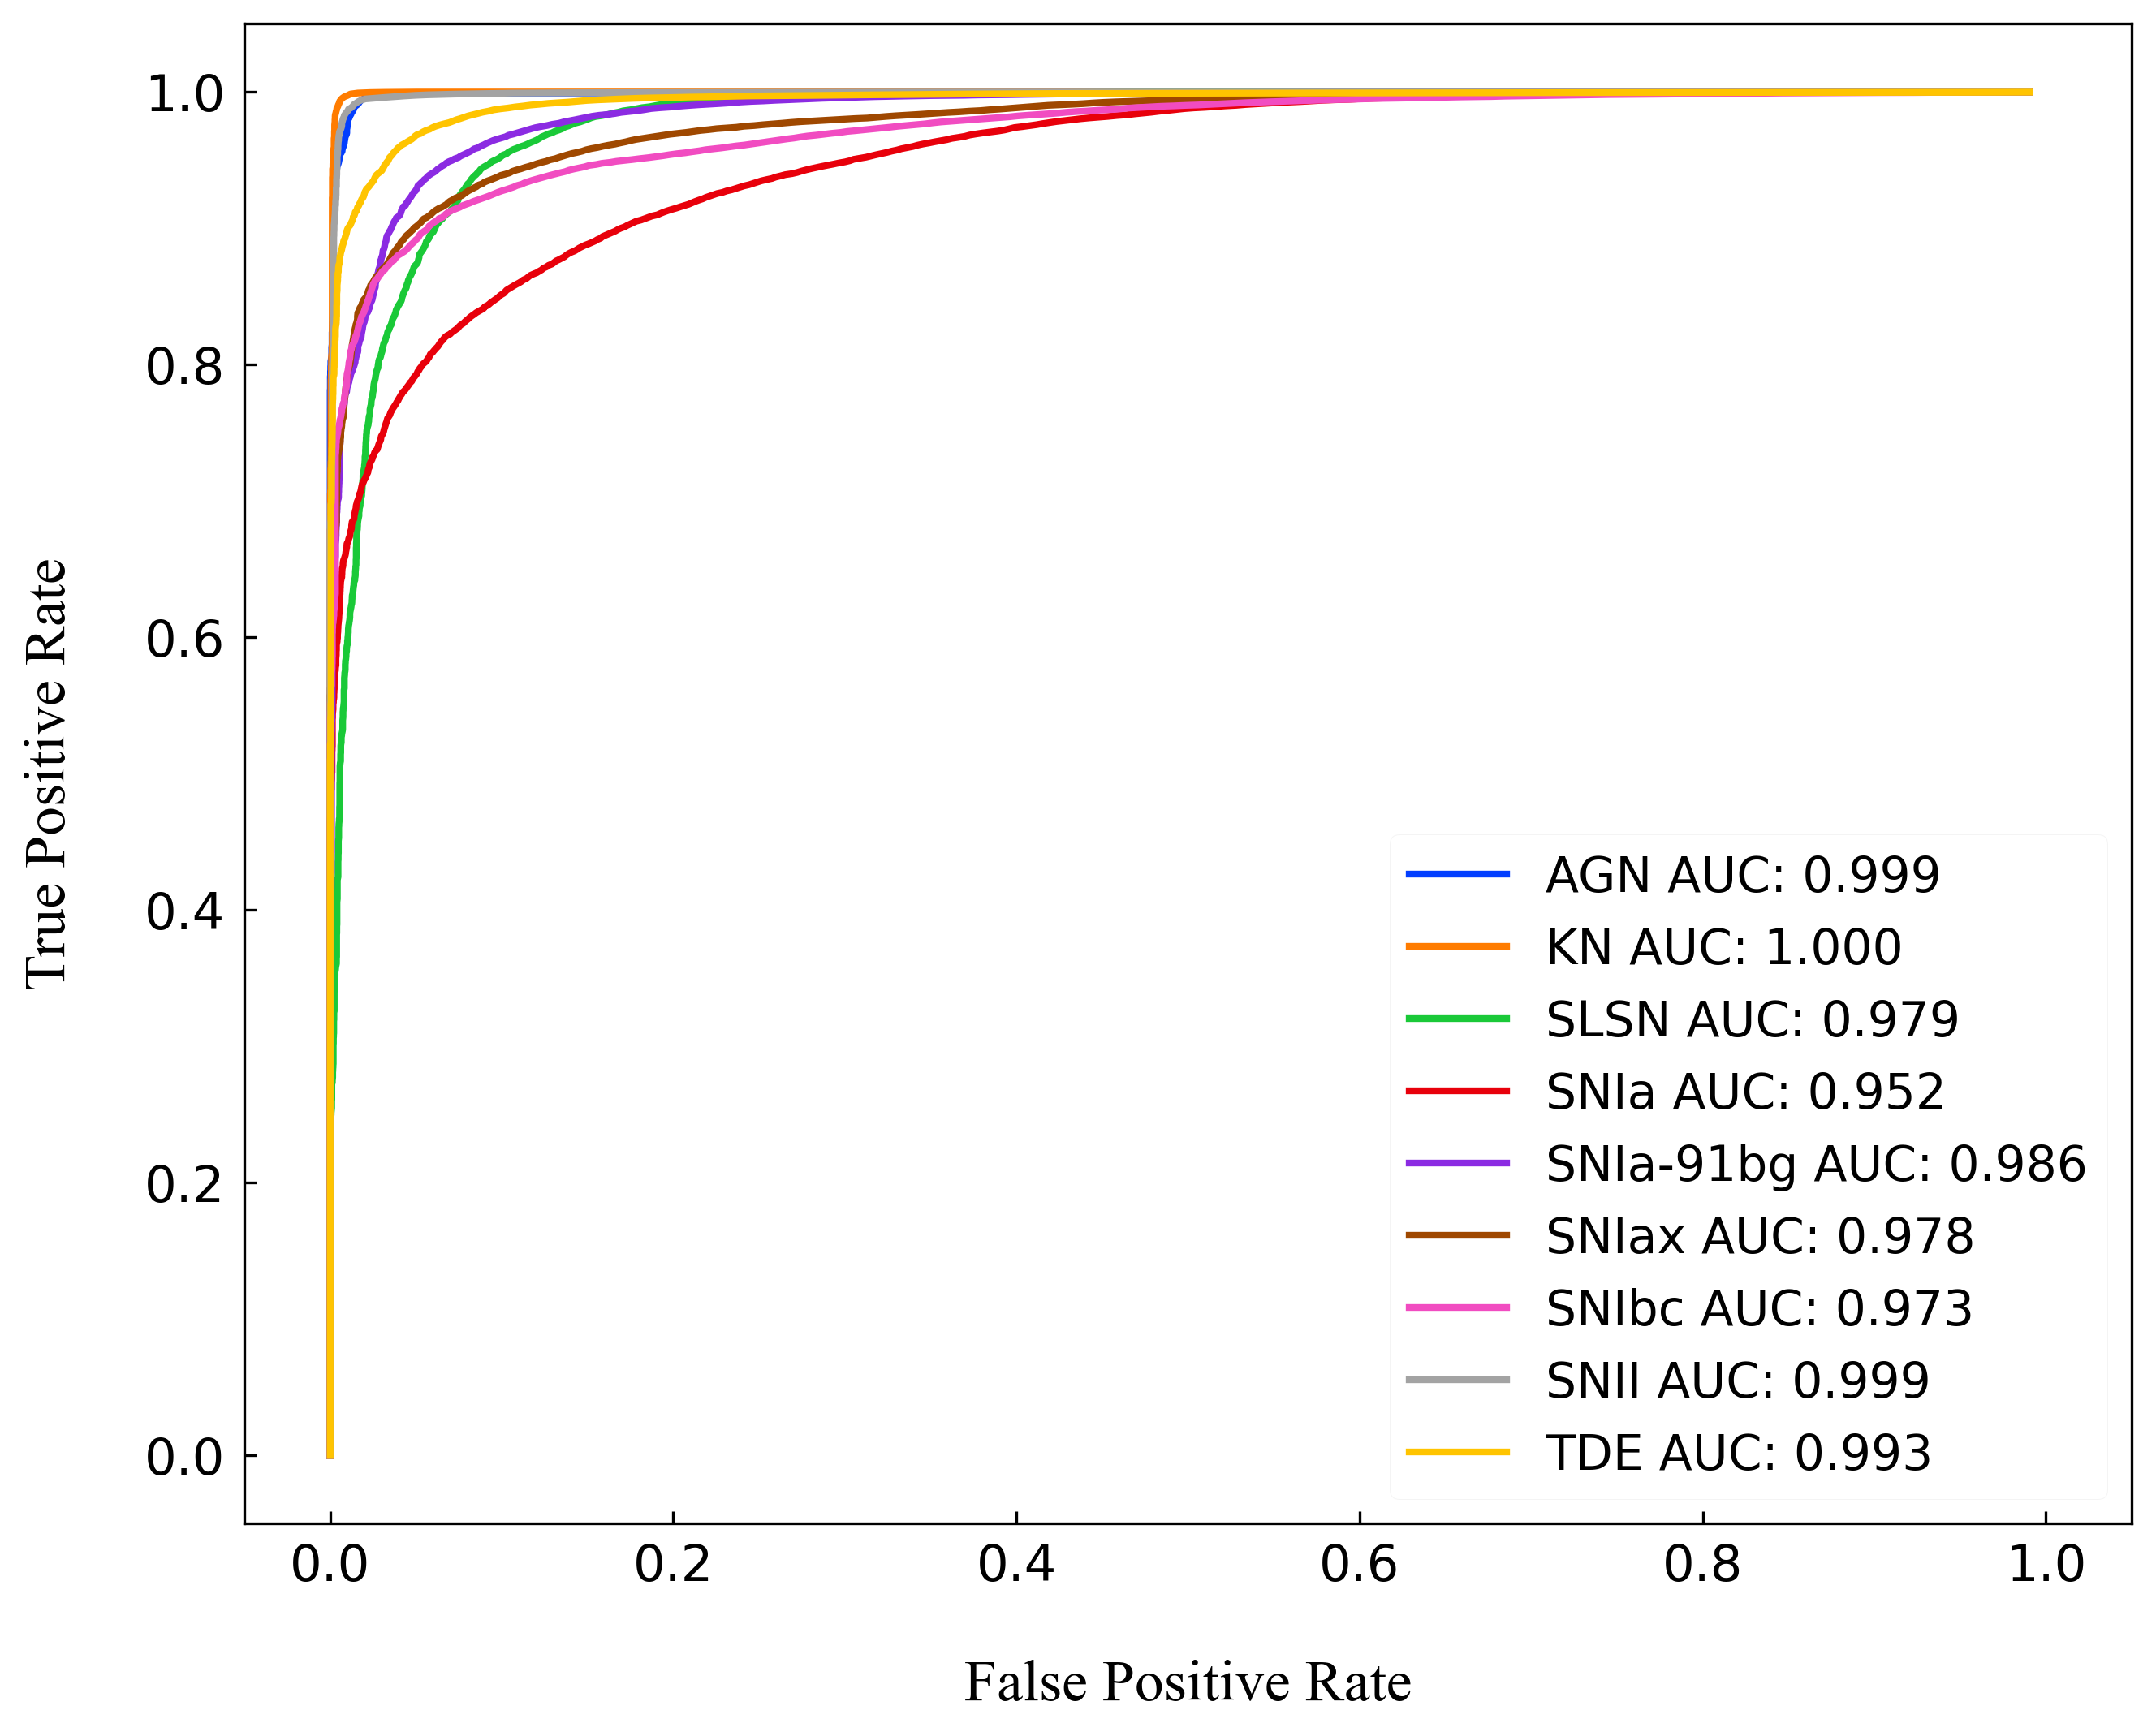

In [53]:
label = [
 'AGN',
 'KN',
 'SLSN',
 'SNIa',
 'SNIa-91bg',
 'SNIax',
 'SNIbc',
 'SNII',
 'TDE']
figure,ax = plt.subplots(1,1,
                        figsize=(10,8),
                        dpi=300
)

for i in range(9):
    x = recall_list[i]
    y = fpr_list[i]
    ax.plot(x,y, label=f"{label[i]} AUC: {AUC_list[i]:.3f}",color=colors[i],lw=2.0, alpha=1.0)
    ax.set_xlim(-0.05,1.05)
    ax.set_ylim(-0.05,1.05)

    #ax.set_xlim(-0.01,0.5)
    #ax.set_ylim(0.8,1.01)

    ax.set_ylabel("True Positive Rate",fontsize="xx-large", labelpad=20,fontproperties="Times New Roman") 
    ax.set_xlabel("False Positive Rate",fontsize="xx-large", labelpad=20,fontproperties="Times New Roman")
 
    ax.tick_params(axis='y',
                     labelsize=15, # y轴字体大小设置
                     #color='r',    # y轴标签颜色设置  
                     #labelcolor='b', # y轴字体颜色设置
                     direction='in' # y轴标签方向设置
                      ) 
    
    ax.tick_params(axis='x',
                     labelsize=15, # y轴字体大小设置
                     #color='r',    # y轴标签颜色设置  
                     #labelcolor='b', # y轴字体颜色设置
                     direction='in' # y轴标签方向设置
                      ) 
    ax.legend(fontsize="x-large",
                      #bbox_to_anchor=(0,0.34,1.028, 1),
                      loc="lower right",
                      framealpha=0.2,
                      #prop=font1
                     )
    
plt.savefig(f"ROC_curve_{mask_time}.jpg",bbox_inches='tight')
plt.show()